In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
# import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
peak_hours_path = "2022-peak-hours-ca - 2022 Peak Hour Report.csv"
traffic_volumes_path = "2022 AADT DATA - 2022 AADT DATA.csv"

peak_hours_df = pd.read_csv(peak_hours_path)
traffic_volumes_df = pd.read_csv(traffic_volumes_path)

peak_hours_df.rename(columns={"RTE": "ROUTE", "CO": "COUNTY"}, inplace=True)

""" merging the dataframes """

merged_df = pd.merge(
    traffic_volumes_df,
    peak_hours_df,
    on=["ROUTE", "COUNTY", "PM"],
    how="inner"
)

print(f"Merged {len(merged_df)} rows from Caltrans data.")

Merged 1084 rows from Caltrans data.


In [3]:
print(merged_df.columns)

merged_df[["AM_DAY","PM_DAY","DISTRICT","ROUTE","COUNTY"]]

Index(['DISTRICT', 'ROUTE', 'ROUTE_SFX', 'COUNTY', 'PM_PFX_x', 'PM',
       'PM_SFX_x', 'LOCATION DESCRIPTION', 'BACK_PEAK_HOUR', 'BACK_PEAK_MADT',
       'BACK_AADT', 'AHEAD_PEAK_HOUR', 'AHEAD_PEAK_MADT', 'AHEAD_AADT', 'DI',
       'RTE_SFX', 'PM_PFX_y', 'PM_SFX_y', 'CS', 'LEG', 'YR', 'AM_DIR',
       'AM_WAY_PHV', 'AM_K_FACTOR_AMT', 'AM_D_FACTOR_AMT', 'AM_KD_FACTOR',
       'AM_HOUR', 'AM_DAY', 'AM_MONTH', 'PM_DIR', 'PM_WAY_PHV',
       'PM_K_FACTOR_AMT', 'PM_D_FACTOR_AMT', 'PM_KD_FACTOR', 'PM_HOUR',
       'PM_DAY', 'PM_MONTH'],
      dtype='object')


,AM_DAY,PM_DAY,DISTRICT,ROUTE,COUNTY
0,TUE,THU,5,1,SB
1,THU,THU,5,1,SB
2,SAT,FRI,5,1,SB
3,TUE,THU,5,1,SB
4,MON,WED,5,1,SB
...,...,...,...,...,...
1079,TUE,TUE,11,805,SD
1080,TUE,THU,11,805,SD
1081,SAT,SAT,4,880,ALA
1082,WED,FRI,11,905,SD


important columns are 
- ROUTE
- COUNTY
- DAY : day of the week
- PHV : peak hour volume
- AM_DIR : direction of travel for peak volume in morning
- PM_DIR : direction of travel for peak volume in at night
- AADT : annual average daily traffic in vehicles per day

- 
- PM_HOUR : post-mile hour


In [4]:
merged_df[["BACK_PEAK_HOUR","AHEAD_PEAK_HOUR", "PM_HOUR","AM_HOUR"]]  # usually the opposite or also the same

,BACK_PEAK_HOUR,AHEAD_PEAK_HOUR,PM_HOUR,AM_HOUR
0,NaN,860.0,16,6
1,900.0,1400.0,17,6
2,1700.0,1000.0,15,12
3,2700.0,2700.0,17,7
4,2700.0,2000.0,17,7
...,...,...,...,...
1079,14500.0,14200.0,14,6
1080,9600.0,NaN,16,8
1081,13500.0,14600.0,13,10
1082,870.0,2950.0,15,7


In [5]:
# merged_df.head()
# merged_df.columns

In [6]:
merged_df.replace({
    'JAN': 0, 'FEB': 1, 'MAR': 2, 'APR': 3,
    'MAY': 4, 'JUN': 5, 'JUL': 6, 'AUG': 7,
    'SEP': 8, 'OCT': 9, 'NOV': 10, 'DEC': 11
}, inplace=True)

merged_df.replace({
    'MON': 0, 'TUE': 1, 'WED': 2, 'THU': 3,
    'FRI': 4, 'SAT': 5, 'SUN': 6
}, inplace=True)

merged_df.replace({'N': 0, 'S': 1, 'E': 2, 'W': 3}, inplace=True)

/var/folders/y0/tql4kxn91m51l1_d96hty_z40000gn/T/ipykernel_9562/837827291.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.replace({
/var/folders/y0/tql4kxn91m51l1_d96hty_z40000gn/T/ipykernel_9562/837827291.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.replace({
/var/folders/y0/tql4kxn91m51l1_d96hty_z40000gn/T/ipykernel_9562/837827291.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_o

## Understanding the AADT Columns

AHEAD means North of a location.
BACK means South of a location. 

These are usually the same because the cars to a location are the same cars coming back from a location. 

- Back Peak Hour - is the estimated volume of traffic going south of a location during RUSH HOUR
- Back Peak MADT - is the estimated MONTHLY volume of traffic going south of a location during RUSH HOUR
- Back Peak AADT - is the estimated ANNUAL volume of traffic going south of a location during RUSH HOUR

In [7]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# --- Simulated multiplier function (adjust if needed)
def calculate_multiplier(back_peak_hour, ahead_peak_hour, back_aadt, ahead_aadt, am_hour=None, pm_hour=None):
    base_multiplier = 1.0

    # Peak Hour Boost
    if pm_hour is not None and (abs(pm_hour - back_peak_hour) <= 1 or abs(pm_hour - ahead_peak_hour) <= 1):
        base_multiplier += 0.6

    # Morning boost
    if am_hour is not None and 7 <= am_hour <= 9:
        base_multiplier += 0.3

    # Night reduction
    if pm_hour is not None and (pm_hour >= 23 or pm_hour <= 5):
        base_multiplier -= 0.3

    # Midday moderate boost
    if pm_hour is not None and 11 <= pm_hour <= 13:
        base_multiplier += 0.2

    # AADT scaling
    avg_aadt = (back_aadt + ahead_aadt) / 2
    base_multiplier += avg_aadt / 400000

    # Add small noise
    return max(base_multiplier + np.random.normal(0, 0.05), 1.0)

# --- Encode functions
def encode_month(month):
    return int(month) if pd.notna(month) else 0

def encode_day(day):
    return int(day) if pd.notna(day) else 0

X_morning, y_morning = [], []
X_night, y_night = [], []

for i, row in merged_df.iterrows():
    try:
        # Safe parsing
        am_month = encode_month(row.get("AM_MONTH"))
        am_day = encode_day(row.get("AM_DAY"))
        am_hour = row.get("AM_HOUR")
        pm_month = encode_month(row.get("PM_MONTH"))
        pm_day = encode_day(row.get("PM_DAY"))
        pm_hour = row.get("PM_HOUR")
        back_aadt = row.get("BACK_AADT")
        ahead_aadt = row.get("AHEAD_AADT")
        back_peak = row.get("BACK_PEAK_HOUR")
        ahead_peak = row.get("AHEAD_PEAK_HOUR")

        # Check required fields
        if any(pd.isna(v) for v in [am_hour, pm_hour, back_aadt, ahead_aadt, back_peak, ahead_peak]):
            continue

        # Convert to int/float safely
        am_hour = int(am_hour)
        pm_hour = int(pm_hour)
        back_aadt = float(back_aadt)
        ahead_aadt = float(ahead_aadt)
        back_peak = int(back_peak)
        ahead_peak = int(ahead_peak)

        # Append to morning
        X_morning.append([am_month, am_day, am_hour, back_aadt, ahead_aadt])
        y_morning.append(calculate_multiplier(back_peak, ahead_peak, back_aadt, ahead_aadt, am_hour=am_hour))

        # Append to night
        X_night.append([pm_month, pm_day, pm_hour, back_aadt, ahead_aadt])
        y_night.append(calculate_multiplier(back_peak, ahead_peak, back_aadt, ahead_aadt, pm_hour=pm_hour))

    except Exception as e:
        print(f"Row {i} skipped due to error: {e}")
        continue

print(f"Prepared {len(X_morning)} morning and {len(X_night)} night examples.")


# --- SVM training helper
def train_svm(X, y):
    X = np.array(X)
    y = np.array(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    score = model.score(X_test, y_test)
    # r2 = r2_score(y_test, y_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"SVM R² score: {score:.3f}")
    print(f"SVM MAE: {mae:.3f}")
    print(f"SVM RMSE: {rmse:.3f}")

    # --- 1. Predicted vs Actual ---
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel("Actual Multiplier")
    plt.ylabel("Predicted Multiplier")
    plt.title("Actual vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 2. Residual Plot ---
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel("Prediction Error (Residual)")
    plt.title("Distribution of Residuals")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 3. Feature Importance (if names provided) ---
    if feature_names is not None:
        results = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        importance = results.importances_mean
        sorted_idx = importance.argsort()[::-1]

        plt.figure(figsize=(8, 5))
        sns.barplot(x=importance[sorted_idx], y=np.array(feature_names)[sorted_idx])
        plt.title("Feature Importance (Permutation)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

    return model, scaler

    return model, scaler

# --- Train both models
morning_svm, morning_scaler = train_svm(X_morning, y_morning)
night_svm, night_scaler = train_svm(X_night, y_night)


Prepared 907 morning and 907 night examples.
SVM R² score: 0.875
SVM MAE: 0.063
SVM RMSE: 0.084


NameError: name 'sns' is not defined

<Figure size 600x600 with 0 Axes>

## Understanding our Data

In [ ]:
print(X_train[:5])  # First 5 rows of the feature matrix
print(y_train[:5])  # First 5 target values

# ["AM_DIRECTION","PM_DIRECTION","PM_HOUR","BACK_PEAK_HOUR","AHEAD_PEAK_HOUR","BACK_AADT","AHEAD_AADT"]

# [
#   AM_HOUR,           # 12, 12am
#   PM_HOUR,           # 13, 1pm
#   AM_DIRECTION,      # 3 → e.g., "W" if you used {'N':0, 'S':1, 'E':2, 'W':3}
#   PM_DIRECTION,      # 3 → same as above
#   PM_HOUR,           # 13 → 1 PM
#   BACK_PEAK_HOUR,    # 2600 → likely a mistake: should be an hour (0-23)
#   AHEAD_PEAK_HOUR,   # 1850 → also possibly invalid as a peak hour
#   BACK_AADT,         # 19400 → realistic
#   AHEAD_AADT         # 14100 → realistic
# ]

[[3.00e+00 3.00e+00 2.60e+03 1.85e+03 1.94e+04 1.41e+04]
 [2.00e+00 2.00e+00 2.55e+03 2.05e+03 2.29e+04 1.84e+04]
 [2.00e+00 2.00e+00 9.20e+02 8.90e+02 9.30e+03 8.50e+03]
 [1.00e+00 1.00e+00 3.35e+03 5.70e+03 3.50e+04 5.90e+04]
 [2.00e+00 2.00e+00 1.88e+04 2.18e+04 2.01e+05 1.86e+05]]
[1.46633391 1.53564456 1.4478639  1.53942597 1.60904012]


In [ ]:
np.mean(y_test)

1.5196991196612806

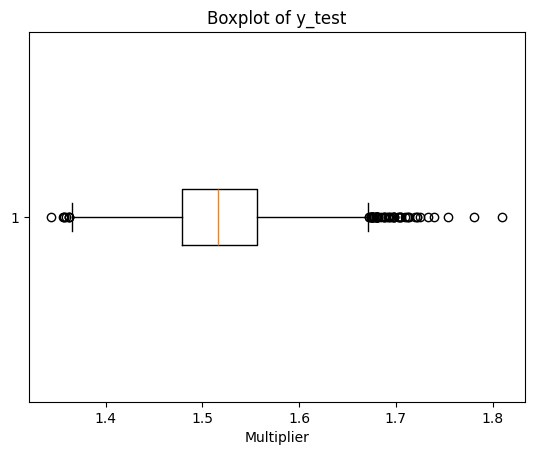

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot(y_test, vert=False)
plt.title("Boxplot of y_test")
plt.xlabel("Multiplier")
plt.show()


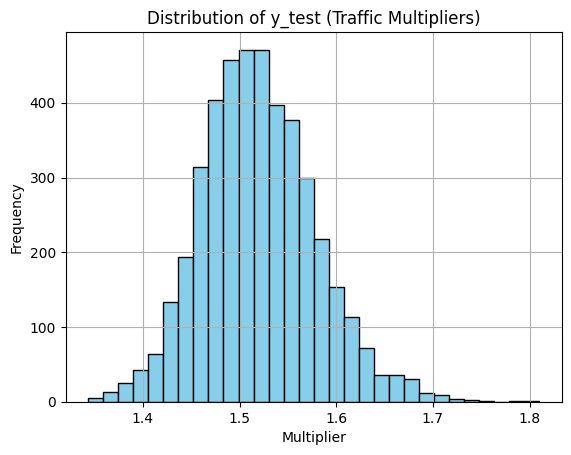

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_test, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of y_test (Traffic Multipliers)")
plt.xlabel("Multiplier")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
def interpret_prediction(model_input, prediction):
    direction_map = {0: 'North', 1: 'South', 2: 'East', 3: 'West'}
    
    am_dir_code, pm_dir_code, back_peak, ahead_peak, back_aadt, ahead_aadt = model_input[0]
    
    am_direction = direction_map.get(am_dir_code, 'Unknown')
    pm_direction = direction_map.get(pm_dir_code, 'Unknown')
    
    summary = (
        f"At heading {pm_direction}, "
        f"traffic is expected to be {prediction[0]:.2f}× heavier than normal.\n"
        f"This is due to:\n"
        f"- Morning conditions: heading {am_direction}\n"
        f"- Nearby peak hours: BACK at {back_peak}:00, AHEAD at {ahead_peak}:00\n"
        f"- Traffic volumes: BACK AADT = {back_aadt}, AHEAD AADT = {ahead_aadt}"
    )
    return summary

In [ ]:
model_test = [[8, 13, 7, 16, 19400, 14100]]
test = model.predict(model_test)
print(interpret_prediction(model_test, test))

At heading Unknown, traffic is expected to be 1.52× heavier than normal.
This is due to:
- Morning conditions: heading Unknown
- Nearby peak hours: BACK at 7:00, AHEAD at 16:00
- Traffic volumes: BACK AADT = 19400, AHEAD AADT = 14100
